In [1]:
from itertools import product
import json
import logging
import math
import pickle

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost as xgb

In [2]:
test_size = 0.3
valid_size = 0.5 # of train_data
train_size = 1-test_size
random_seed = 112

In [3]:
logging.basicConfig(level=logging.INFO)

In [3]:
data = pd.read_csv('orgs_w_sentences.csv')

In [23]:
data['sentences'] = data['sentences'].apply(json.loads)

In [24]:
data['sentences'] = data['sentences'].apply(' '.join)

### Разбиение на тестовую и тренировочную выборки:

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113798 entries, 0 to 113797
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   uuid             113798 non-null  object 
 1   organization     113798 non-null  object 
 2   sentiment_score  113798 non-null  float64
 3   sentiment_label  113798 non-null  object 
 4   org_relevance    113798 non-null  float64
 5   org_count        113798 non-null  int64  
 6   confidence       113797 non-null  float64
 7   orgs_in_doc      113798 non-null  int64  
 8   label            113570 non-null  object 
 9   org_id           113798 non-null  object 
 10  sentences        113798 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 9.6+ MB


In [26]:
data.dropna(inplace=True)

In [27]:
data.shape

(113569, 11)

In [29]:
train_data, test_data = train_test_split(data, test_size=test_size, train_size=train_size, random_state=random_seed)
del data

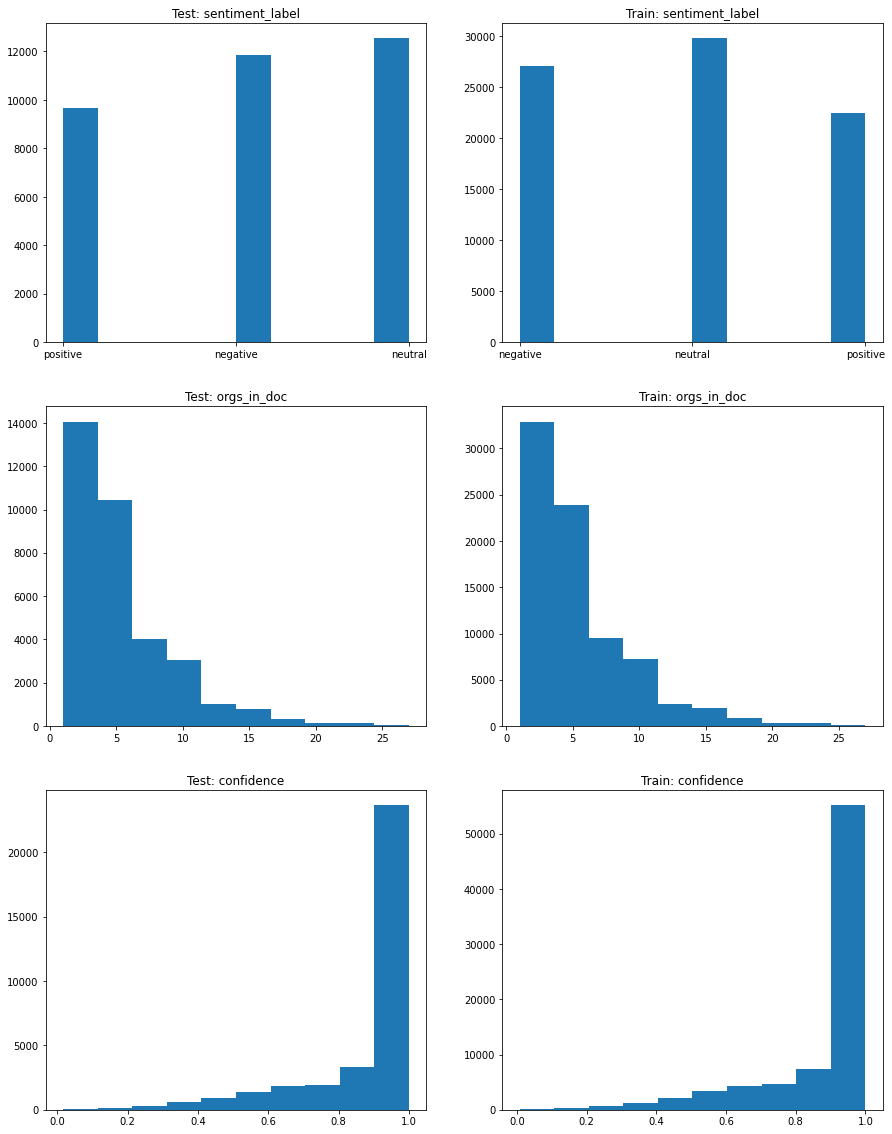

In [30]:
figure = plt.figure(figsize=(15,20))
columns_to_compare = ['sentiment_label','orgs_in_doc','confidence']
for i,column in enumerate(columns_to_compare):
    ax_test = figure.add_subplot(int(f'32{2*i+1}'))
    ax_train = figure.add_subplot(int(f'32{2*i+2}'))
    ax_test.hist(test_data[column])
    ax_test.set_title(f'Test: {column}')
    ax_train.hist(train_data[column])
    ax_train.set_title(f'Train: {column}')

### Feature Engineering

In [31]:
bow_uni_vectorizer = CountVectorizer(
        lowercase=False, 
        dtype=np.float32, 
        ngram_range=(1,1),
)
bow_uni_bi_vectorizer = CountVectorizer(
        lowercase=False, 
        dtype=np.float32, 
        ngram_range=(1,2),
)

In [32]:
train_uni = bow_uni_vectorizer.fit_transform(train_data['sentences'])
test_uni = bow_uni_vectorizer.transform(test_data['sentences'])
total_uni = scipy.sparse.vstack((train_uni, test_uni))
uni_sentences = {
    'train': train_uni,
    'test': test_uni,
    'total': total_uni,
}
del train_uni, test_uni, total_uni

train_bi = bow_uni_bi_vectorizer.fit_transform(train_data['sentences'])
test_bi = bow_uni_bi_vectorizer.transform(test_data['sentences'])
total_bi = scipy.sparse.vstack((train_bi, test_bi))

bi_sentences = {
    'train': train_bi,
    'test': test_bi,
    'total': total_bi,
}
del train_bi, test_bi, total_bi

In [33]:
with open('bi_sentences.pickle','wb') as file:
    pickle.dump(bi_sentences,file)
with open('uni_sentences.pickle','wb') as file:
    pickle.dump(uni_sentences,file)

In [34]:
labelencoder = LabelEncoder()
train_y = labelencoder.fit_transform(train_data['sentiment_label'])
test_y = labelencoder.transform(test_data['sentiment_label'])
total_y = np.hstack((train_y, test_y))

In [35]:
target = {
    'train': train_y,
    'test': test_y,
    'total': total_y,
}

In [36]:
with open('target.pickle','wb') as file:
    pickle.dump(target,file)

In [37]:
del train_data, test_data, train_y, test_y, target, bi_sentences, uni_sentences

### Random Forest

In [4]:
with open('bi_sentences.pickle','rb') as file:
    bi_sentences = pickle.load(file)
with open('uni_sentences.pickle','rb') as file:
    uni_sentences = pickle.load(file)
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [5]:
n_estimators = 100

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, n_jobs=2)

In [7]:
%%time
train_x = bi_sentences['train']
test_x = bi_sentences['test']
train_y = target['train']
test_y = target['test']

logging.info('Unigram and bigram RF:\n')

logging.info('Start fitting.')
rf_classifier.fit(train_x, train_y)

logging.info('Start predicting.')
pred_y = rf_classifier.predict(test_x)

result = classification_report(test_y, pred_y)
logging.info(result)

INFO:root:Unigram and bigram RF:

INFO:root:Start fitting.
INFO:root:Start predicting.
INFO:root:              precision    recall  f1-score   support

           0       0.80      0.84      0.82     11857
           1       0.74      0.89      0.81     12564
           2       0.86      0.58      0.69      9650

    accuracy                           0.78     34071
   macro avg       0.80      0.77      0.77     34071
weighted avg       0.79      0.78      0.78     34071



CPU times: user 4h 26min 1s, sys: 2.03 s, total: 4h 26min 3s
Wall time: 2h 13min 59s


In [8]:
%%time
train_x = uni_sentences['train']
test_x = uni_sentences['test']
train_y = target['train']
test_y = target['test']

logging.info('Unigram RF:\n')

logging.info('Start fitting.')
rf_classifier.fit(train_x, train_y)

logging.info('Start predicting.')
pred_y = rf_classifier.predict(test_x)

result = classification_report(test_y, pred_y)
logging.info(result)

INFO:root:Unigram RF:

INFO:root:Start fitting.
INFO:root:Start predicting.
INFO:root:              precision    recall  f1-score   support

           0       0.79      0.85      0.82     11857
           1       0.77      0.87      0.82     12564
           2       0.84      0.61      0.70      9650

    accuracy                           0.79     34071
   macro avg       0.80      0.78      0.78     34071
weighted avg       0.79      0.79      0.78     34071



CPU times: user 18min 47s, sys: 781 ms, total: 18min 47s
Wall time: 9min 27s


In [57]:
metrics = ['precision_weighted', 'recall_weighted','f1_weighted']
total_x = uni_sentences['total']
total_y = target['total']
svd = TruncatedSVD(n_components=100,random_state=random_seed)
svd.fit(total_x)
total_x_svd = svd.transform(total_x)

In [64]:
cv_results = cross_validate(rf_classifier, total_x_svd, total_y, scoring=metrics)
logging.info(cv_results)

{'fit_time': array([65.69319296, 64.34045577, 64.77827787, 67.69439435, 68.48325896]),
 'score_time': array([0.35344601, 0.37324524, 0.36176252, 0.41801596, 0.3451767 ]),
 'test_precision_weighted': array([0.78047289, 0.77679446, 0.77487083, 0.77437824, 0.77532157]),
 'test_recall_weighted': array([0.78061988, 0.77665757, 0.77489654, 0.7741481 , 0.77506274]),
 'test_f1_weighted': array([0.77805437, 0.773644  , 0.77193228, 0.77143612, 0.77212252])}

In [65]:
total_x = bi_sentences['total']
svd = TruncatedSVD(n_components=100,random_state=random_seed)
svd.fit(total_x)
total_x_svd = svd.transform(total_x)

In [66]:
cv_results = cross_validate(rf_classifier, total_x_svd, total_y, scoring=metrics)
logging.info(cv_results)

{'fit_time': array([69.75454187, 65.48771214, 65.77743316, 65.74963188, 64.7651031 ]),
 'score_time': array([0.33135581, 0.43488503, 0.3546207 , 0.36747646, 0.40091586]),
 'test_precision_weighted': array([0.77858392, 0.77607556, 0.7760811 , 0.77438439, 0.7734366 ]),
 'test_recall_weighted': array([0.77885885, 0.77577705, 0.7755129 , 0.77410408, 0.7735658 ]),
 'test_f1_weighted': array([0.77632447, 0.7727957 , 0.772707  , 0.77137694, 0.77061984])}

Лучший результат оказался:
<code>
RandomForestClassifier(random_state=112)
Start fitting
Start predicting
           precision    recall  f1-score   support

           0       0.80      0.86      0.82      7831
           1       0.78      0.88      0.83      8408
           2       0.85      0.63      0.73      6475

    accuracy                           0.80     22714
   macro avg       0.81      0.79      0.79     22714
weighted avg       0.81      0.80      0.80     22714
</code>
на данных:
bow_unigram_mif1_maf1.0

## xgboost

In [67]:
with open('bi_sentences.pickle','rb') as file:
    bi_sentences = pickle.load(file)
with open('uni_sentences.pickle','rb') as file:
    uni_sentences = pickle.load(file)
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [68]:
train_x = uni_sentences['train']
test_x = uni_sentences['test']
train_y = target['train']
test_y = target['test']

In [69]:
xg_train = xgb.DMatrix(train_x, label=train_y)
xg_test = xgb.DMatrix(test_x, label=test_y)

In [70]:
base_params = {
    'max_depth':10, 
    'eta':0.3, 
    'objective':'multi:softmax',
    'num_class': 3,
    'min_child_weight': 1,
}

In [71]:
def test_xgboost(etas, max_depths, num_rounds):
    params = []
    for eta, max_depth in product(etas,max_depths):
        param = base_params.copy()
        param['eta'] = eta
        param['max_depth'] = max_depth
        params.append(param)
    for num_round in num_rounds:
        for param in params:
            name = f'xg_boost_uni_{num_round}_{param["eta"]}_{param["max_depth"]}'
            logging.info(name)
            models_reports[name] = {}
            bst = xgb.train(param, xg_train, num_round)
            pred_y = bst.predict(xg_test)
            result = classification_report(test_y, pred_y)
            logging.info(result)
            bst.dump_model(f'{name}.bst')

In [72]:
etas = [0.3]
max_depths = [8,10]
num_rounds = [10,100]
test_xgboost(etas, max_depths, num_rounds)

INFO:root:xg_boost_uni_10_0.3_8
INFO:root:              precision    recall  f1-score   support

           0       0.65      0.68      0.67     11857
           1       0.60      0.81      0.69     12564
           2       0.66      0.34      0.45      9650

    accuracy                           0.63     34071
   macro avg       0.64      0.61      0.60     34071
weighted avg       0.64      0.63      0.61     34071

INFO:root:xg_boost_uni_10_0.3_10
INFO:root:              precision    recall  f1-score   support

           0       0.67      0.69      0.68     11857
           1       0.62      0.82      0.71     12564
           2       0.67      0.38      0.48      9650

    accuracy                           0.65     34071
   macro avg       0.65      0.63      0.62     34071
weighted avg       0.65      0.65      0.63     34071

INFO:root:xg_boost_uni_100_0.3_8
INFO:root:              precision    recall  f1-score   support

           0       0.76      0.75      0.76     11857
 

Лучший результат:
<code>
xg_boost_uni_100_0.3_10
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     11857
           1       0.72      0.85      0.78     12564
           2       0.75      0.59      0.66      9650

    accuracy                           0.75     34071
   macro avg       0.75      0.74      0.74     34071
weighted avg       0.75      0.75      0.74     34071
</code>

### LightGBM

In [15]:
with open('bi_sentences.pickle','rb') as file:
    bi_sentences = pickle.load(file)
with open('uni_sentences.pickle','rb') as file:
    uni_sentences = pickle.load(file)
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [16]:
train_x = uni_sentences['train']
test_x = uni_sentences['test']
train_y = target['train']
test_y = target['test']

In [17]:
train_data = lgb.Dataset(train_x, label=train_y)
test_data = lgb.Dataset(test_x, label=test_y, reference=train_data)

In [19]:
base_params = {
    'objective':'multiclass',
    'boosting': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'verbose':0,
}

In [80]:
num_iterations = [100,500]
learning_rates = [0.01,0.3]
num_leaves = [31,100,300]

In [81]:
params = []
for num_iter, learn_rate, num_leave in product(num_iterations, learning_rates, num_leaves):
    param = base_params.copy()
    param['num_iterations'] = num_iter
    param['learning_rate'] = learn_rate
    param['num_leaves'] = num_leave
    params.append(param)

In [82]:
results = {}
for param in params:
    name = f'lightgbm_{param["num_iterations"]}_{param["learning_rate"]}_{param["num_leaves"]}'
    logging.info(f'{name}')
    bst = lgb.train(param, train_data, valid_sets=[test_data])
    pred_y = bst.predict(test_x).argmax(axis=1)
    report = classification_report(test_y,pred_y)
    logging.info(report)
    with open(f'{name}.pickle','wb') as file:
        pickle.dump(bst, file)

INFO:root:lightgbm_100_0.01_31
/home/pontianak/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.411354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.08907
[2]	valid_0's multi_logloss: 1.08559
[3]	valid_0's multi_logloss: 1.08217
[4]	valid_0's multi_logloss: 1.07882
[5]	valid_0's multi_logloss: 1.07554
[6]	valid_0's multi_logloss: 1.07231
[7]	valid_0's multi_logloss: 1.06915
[8]	valid_0's multi_logloss: 1.06604
[9]	valid_0's multi_logloss: 1.063
[10]	valid_0's multi_logloss: 1.06001
[11]	valid_0's multi_logloss: 1.05706
[12]	valid_0's multi_logloss: 1.05416
[13]	valid_0's multi_logloss: 1.05132
[14]	valid_0's multi_logloss: 1.04854
[15]	valid_0's multi_logloss: 1.04579
[16]	valid_0's multi_logloss: 1.04312
[17]	valid_0's multi_logloss: 1.04045
[18]	valid_0's multi_logloss: 1.03785
[19]	valid_0's multi_logloss: 1.03527
[20]	valid_0's multi_logloss: 1.03276
[21]	valid_0's multi_l

INFO:root:              precision    recall  f1-score   support

           0       0.59      0.74      0.65     11857
           1       0.60      0.74      0.66     12564
           2       0.64      0.25      0.36      9650

    accuracy                           0.60     34071
   macro avg       0.61      0.58      0.56     34071
weighted avg       0.61      0.60      0.57     34071

INFO:root:lightgbm_100_0.01_100


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.510463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.08825
[2]	valid_0's multi_logloss: 1.08396
[3]	valid_0's multi_logloss: 1.07973
[4]	valid_0's multi_logloss: 1.07556
[5]	valid_0's multi_logloss: 1.07151
[6]	valid_0's multi_logloss: 1.06752
[7]	valid_0's multi_logloss: 1.06361
[8]	valid_0's multi_logloss: 1.05979
[9]	valid_0's multi_logloss: 1.05601
[10]	valid_0's multi_logloss: 1.05231
[11]	valid_0's multi_logloss: 1.04868
[12]	valid_0's multi_logloss: 1.04513
[13]	valid_0's multi_logloss: 1.04161
[14]	valid_0's multi_logloss: 1.03818
[15]	valid_0's multi_logloss: 1.03479
[16]	valid_0's multi_logloss: 1.03147
[17]	valid_0's multi_logloss: 1.0282
[18]	valid_0's multi_logloss: 1.02497
[19]	valid_0's multi_logloss: 1.02177
[20]	valid_0's multi_logloss: 1.01867
[21]	valid_0's multi_

INFO:root:              precision    recall  f1-score   support

           0       0.64      0.74      0.69     11857
           1       0.63      0.79      0.70     12564
           2       0.68      0.34      0.45      9650

    accuracy                           0.64     34071
   macro avg       0.65      0.62      0.62     34071
weighted avg       0.65      0.64      0.63     34071

INFO:root:lightgbm_100_0.01_300


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.045053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.08736
[2]	valid_0's multi_logloss: 1.08217
[3]	valid_0's multi_logloss: 1.07709
[4]	valid_0's multi_logloss: 1.07209
[5]	valid_0's multi_logloss: 1.0672
[6]	valid_0's multi_logloss: 1.06238
[7]	valid_0's multi_logloss: 1.05767
[8]	valid_0's multi_logloss: 1.05303
[9]	valid_0's multi_logloss: 1.04847
[10]	valid_0's multi_logloss: 1.04401
[11]	valid_0's multi_logloss: 1.03963
[12]	valid_0's multi_logloss: 1.03535
[13]	valid_0's multi_logloss: 1.03113
[14]	valid_0's multi_logloss: 1.02701
[15]	valid_0's multi_logloss: 1.02295
[16]	valid_0's multi_logloss: 1.01894
[17]	valid_0's multi_logloss: 1.01499
[18]	valid_0's multi_logloss: 1.01112
[19]	valid_0's multi_logloss: 1.00731
[20]	valid_0's multi_logloss: 1.00357
[21]	valid_0's multi_logloss: 0.9999
[22]	valid_0's multi_logloss: 0.996291
[23]	vali

INFO:root:              precision    recall  f1-score   support

           0       0.69      0.76      0.72     11857
           1       0.67      0.81      0.73     12564
           2       0.72      0.43      0.54      9650

    accuracy                           0.68     34071
   macro avg       0.69      0.67      0.66     34071
weighted avg       0.69      0.68      0.67     34071

INFO:root:lightgbm_100_0.3_31


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.945524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.00095
[2]	valid_0's multi_logloss: 0.949682
[3]	valid_0's multi_logloss: 0.916077
[4]	valid_0's multi_logloss: 0.892126
[5]	valid_0's multi_logloss: 0.873161
[6]	valid_0's multi_logloss: 0.856086
[7]	valid_0's multi_logloss: 0.840059
[8]	valid_0's multi_logloss: 0.826096
[9]	valid_0's multi_logloss: 0.814418
[10]	valid_0's multi_logloss: 0.804717
[11]	valid_0's multi_logloss: 0.795405
[12]	valid_0's multi_logloss: 0.788029
[13]	valid_0's multi_logloss: 0.78068
[14]	valid_0's multi_logloss: 0.773845
[15]	valid_0's multi_logloss: 0.767586
[16]	valid_0's multi_logloss: 0.761768
[17]	valid_0's multi_logloss: 0.75649
[18]	valid_0's multi_logloss: 0.751864
[19]	valid_0's multi_logloss: 0.747114
[20]	valid_0's multi_logloss: 0.743037
[21

INFO:root:              precision    recall  f1-score   support

           0       0.77      0.77      0.77     11857
           1       0.74      0.82      0.78     12564
           2       0.72      0.61      0.66      9650

    accuracy                           0.74     34071
   macro avg       0.74      0.73      0.74     34071
weighted avg       0.74      0.74      0.74     34071

INFO:root:lightgbm_100_0.3_100


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.665627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 0.979757
[2]	valid_0's multi_logloss: 0.915331
[3]	valid_0's multi_logloss: 0.872938
[4]	valid_0's multi_logloss: 0.842772
[5]	valid_0's multi_logloss: 0.817761
[6]	valid_0's multi_logloss: 0.796944
[7]	valid_0's multi_logloss: 0.779875
[8]	valid_0's multi_logloss: 0.764062
[9]	valid_0's multi_logloss: 0.748448
[10]	valid_0's multi_logloss: 0.73571
[11]	valid_0's multi_logloss: 0.724283
[12]	valid_0's multi_logloss: 0.712453
[13]	valid_0's multi_logloss: 0.703364
[14]	valid_0's multi_logloss: 0.695287
[15]	valid_0's multi_logloss: 0.687956
[16]	valid_0's multi_logloss: 0.680554
[17]	valid_0's multi_logloss: 0.673813
[18]	valid_0's multi_logloss: 0.667809
[19]	valid_0's multi_logloss: 0.662608
[20]	valid_0's multi_logloss: 0.657812
[21]	valid_0's multi_logloss: 0.653645
[22]	valid_0's multi_loglo

INFO:root:              precision    recall  f1-score   support

           0       0.81      0.82      0.81     11857
           1       0.79      0.84      0.81     12564
           2       0.76      0.69      0.72      9650

    accuracy                           0.79     34071
   macro avg       0.79      0.78      0.78     34071
weighted avg       0.79      0.79      0.79     34071

INFO:root:lightgbm_100_0.3_300


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.741900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 0.957751
[2]	valid_0's multi_logloss: 0.880949
[3]	valid_0's multi_logloss: 0.82858
[4]	valid_0's multi_logloss: 0.791789
[5]	valid_0's multi_logloss: 0.762791
[6]	valid_0's multi_logloss: 0.739269
[7]	valid_0's multi_logloss: 0.71798
[8]	valid_0's multi_logloss: 0.698587
[9]	valid_0's multi_logloss: 0.682063
[10]	valid_0's multi_logloss: 0.666665
[11]	valid_0's multi_logloss: 0.653431
[12]	valid_0's multi_logloss: 0.641784
[13]	valid_0's multi_logloss: 0.631634
[14]	valid_0's multi_logloss: 0.62219
[15]	valid_0's multi_logloss: 0.613278
[16]	valid_0's multi_logloss: 0.605203
[17]	valid_0's multi_logloss: 0.598714
[18]	valid_0's multi_logloss: 0.592003
[19]	valid_0's multi_logloss: 0.58599
[20]	valid_0's multi_logloss: 0.581372
[21]

INFO:root:              precision    recall  f1-score   support

           0       0.83      0.84      0.83     11857
           1       0.81      0.85      0.83     12564
           2       0.78      0.72      0.75      9650

    accuracy                           0.81     34071
   macro avg       0.81      0.80      0.80     34071
weighted avg       0.81      0.81      0.81     34071

INFO:root:lightgbm_500_0.01_31


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 7.912896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.08907
[2]	valid_0's multi_logloss: 1.08559
[3]	valid_0's multi_logloss: 1.08217
[4]	valid_0's multi_logloss: 1.07882
[5]	valid_0's multi_logloss: 1.07554
[6]	valid_0's multi_logloss: 1.07231
[7]	valid_0's multi_logloss: 1.06915
[8]	valid_0's multi_logloss: 1.06604
[9]	valid_0's multi_logloss: 1.063
[10]	valid_0's multi_logloss: 1.06001
[11]	valid_0's multi_logloss: 1.05706
[12]	valid_0's multi_logloss: 1.05416
[13]	valid_0's multi_logloss: 1.05132
[14]	valid_0's multi_logloss: 1.04854
[15]	valid_0's multi_logloss: 1.04579
[16]	valid_0's multi_logloss: 1.04312
[17]	valid_0's multi_logloss: 1.04045
[18]	valid_0's multi_logloss: 1.03785
[19]	valid_0's multi_logloss: 1.03527
[20]	valid_0's multi_logloss: 1.03276
[21]	valid_0's multi_l

[206]	valid_0's multi_logloss: 0.848522
[207]	valid_0's multi_logloss: 0.848068
[208]	valid_0's multi_logloss: 0.847586
[209]	valid_0's multi_logloss: 0.847107
[210]	valid_0's multi_logloss: 0.846648
[211]	valid_0's multi_logloss: 0.84614
[212]	valid_0's multi_logloss: 0.845652
[213]	valid_0's multi_logloss: 0.845144
[214]	valid_0's multi_logloss: 0.844643
[215]	valid_0's multi_logloss: 0.844137
[216]	valid_0's multi_logloss: 0.843704
[217]	valid_0's multi_logloss: 0.843219
[218]	valid_0's multi_logloss: 0.842695
[219]	valid_0's multi_logloss: 0.842179
[220]	valid_0's multi_logloss: 0.841654
[221]	valid_0's multi_logloss: 0.841137
[222]	valid_0's multi_logloss: 0.840686
[223]	valid_0's multi_logloss: 0.840203
[224]	valid_0's multi_logloss: 0.839701
[225]	valid_0's multi_logloss: 0.839214
[226]	valid_0's multi_logloss: 0.838739
[227]	valid_0's multi_logloss: 0.838241
[228]	valid_0's multi_logloss: 0.837782
[229]	valid_0's multi_logloss: 0.83732
[230]	valid_0's multi_logloss: 0.836846
[2

[412]	valid_0's multi_logloss: 0.7778
[413]	valid_0's multi_logloss: 0.777575
[414]	valid_0's multi_logloss: 0.777336
[415]	valid_0's multi_logloss: 0.77711
[416]	valid_0's multi_logloss: 0.77687
[417]	valid_0's multi_logloss: 0.776638
[418]	valid_0's multi_logloss: 0.776406
[419]	valid_0's multi_logloss: 0.776184
[420]	valid_0's multi_logloss: 0.775948
[421]	valid_0's multi_logloss: 0.775725
[422]	valid_0's multi_logloss: 0.775503
[423]	valid_0's multi_logloss: 0.775269
[424]	valid_0's multi_logloss: 0.775033
[425]	valid_0's multi_logloss: 0.774809
[426]	valid_0's multi_logloss: 0.774584
[427]	valid_0's multi_logloss: 0.774366
[428]	valid_0's multi_logloss: 0.774146
[429]	valid_0's multi_logloss: 0.773939
[430]	valid_0's multi_logloss: 0.773714
[431]	valid_0's multi_logloss: 0.773508
[432]	valid_0's multi_logloss: 0.773293
[433]	valid_0's multi_logloss: 0.773076
[434]	valid_0's multi_logloss: 0.772861
[435]	valid_0's multi_logloss: 0.77264
[436]	valid_0's multi_logloss: 0.772425
[437]

INFO:root:              precision    recall  f1-score   support

           0       0.69      0.74      0.71     11857
           1       0.67      0.78      0.72     12564
           2       0.66      0.46      0.54      9650

    accuracy                           0.68     34071
   macro avg       0.67      0.66      0.66     34071
weighted avg       0.67      0.68      0.67     34071

INFO:root:lightgbm_500_0.01_100


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.698272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.08825
[2]	valid_0's multi_logloss: 1.08396
[3]	valid_0's multi_logloss: 1.07973
[4]	valid_0's multi_logloss: 1.07556
[5]	valid_0's multi_logloss: 1.07151
[6]	valid_0's multi_logloss: 1.06752
[7]	valid_0's multi_logloss: 1.06361
[8]	valid_0's multi_logloss: 1.05979
[9]	valid_0's multi_logloss: 1.05601
[10]	valid_0's multi_logloss: 1.05231
[11]	valid_0's multi_logloss: 1.04868
[12]	valid_0's multi_logloss: 1.04513
[13]	valid_0's multi_logloss: 1.04161
[14]	valid_0's multi_logloss: 1.03818
[15]	valid_0's multi_logloss: 1.03479
[16]	valid_0's multi_logloss: 1.03147
[17]	valid_0's multi_logloss: 1.0282
[18]	valid_0's multi_logloss: 1.02497
[19]	valid_0's multi_logloss: 1.02177
[20]	valid_0's multi_logloss: 1.01867
[21]	valid_0's multi_logloss: 1.01561
[22]	valid_0's multi_logloss: 1.01259
[23]	vali

[206]	valid_0's multi_logloss: 0.78644
[207]	valid_0's multi_logloss: 0.78587
[208]	valid_0's multi_logloss: 0.785278
[209]	valid_0's multi_logloss: 0.784691
[210]	valid_0's multi_logloss: 0.784082
[211]	valid_0's multi_logloss: 0.783486
[212]	valid_0's multi_logloss: 0.782921
[213]	valid_0's multi_logloss: 0.782353
[214]	valid_0's multi_logloss: 0.78179
[215]	valid_0's multi_logloss: 0.781204
[216]	valid_0's multi_logloss: 0.780624
[217]	valid_0's multi_logloss: 0.780048
[218]	valid_0's multi_logloss: 0.779513
[219]	valid_0's multi_logloss: 0.778974
[220]	valid_0's multi_logloss: 0.778411
[221]	valid_0's multi_logloss: 0.777856
[222]	valid_0's multi_logloss: 0.777305
[223]	valid_0's multi_logloss: 0.776762
[224]	valid_0's multi_logloss: 0.776221
[225]	valid_0's multi_logloss: 0.775647
[226]	valid_0's multi_logloss: 0.775106
[227]	valid_0's multi_logloss: 0.77453
[228]	valid_0's multi_logloss: 0.773959
[229]	valid_0's multi_logloss: 0.7734
[230]	valid_0's multi_logloss: 0.772846
[231]	

[412]	valid_0's multi_logloss: 0.697598
[413]	valid_0's multi_logloss: 0.697293
[414]	valid_0's multi_logloss: 0.696996
[415]	valid_0's multi_logloss: 0.696705
[416]	valid_0's multi_logloss: 0.696423
[417]	valid_0's multi_logloss: 0.696115
[418]	valid_0's multi_logloss: 0.695827
[419]	valid_0's multi_logloss: 0.695546
[420]	valid_0's multi_logloss: 0.695273
[421]	valid_0's multi_logloss: 0.694984
[422]	valid_0's multi_logloss: 0.69471
[423]	valid_0's multi_logloss: 0.69443
[424]	valid_0's multi_logloss: 0.694152
[425]	valid_0's multi_logloss: 0.693879
[426]	valid_0's multi_logloss: 0.693615
[427]	valid_0's multi_logloss: 0.693338
[428]	valid_0's multi_logloss: 0.693045
[429]	valid_0's multi_logloss: 0.692772
[430]	valid_0's multi_logloss: 0.692487
[431]	valid_0's multi_logloss: 0.692226
[432]	valid_0's multi_logloss: 0.691949
[433]	valid_0's multi_logloss: 0.691677
[434]	valid_0's multi_logloss: 0.691403
[435]	valid_0's multi_logloss: 0.691116
[436]	valid_0's multi_logloss: 0.690852
[4

INFO:root:              precision    recall  f1-score   support

           0       0.74      0.77      0.75     11857
           1       0.73      0.80      0.76     12564
           2       0.70      0.57      0.63      9650

    accuracy                           0.72     34071
   macro avg       0.72      0.71      0.71     34071
weighted avg       0.72      0.72      0.72     34071

INFO:root:lightgbm_500_0.01_300


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.474625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.08736
[2]	valid_0's multi_logloss: 1.08217
[3]	valid_0's multi_logloss: 1.07709
[4]	valid_0's multi_logloss: 1.07209
[5]	valid_0's multi_logloss: 1.0672
[6]	valid_0's multi_logloss: 1.06238
[7]	valid_0's multi_logloss: 1.05767
[8]	valid_0's multi_logloss: 1.05303
[9]	valid_0's multi_logloss: 1.04847
[10]	valid_0's multi_logloss: 1.04401
[11]	valid_0's multi_logloss: 1.03963
[12]	valid_0's multi_logloss: 1.03535
[13]	valid_0's multi_logloss: 1.03113
[14]	valid_0's multi_logloss: 1.02701
[15]	valid_0's multi_logloss: 1.02295
[16]	valid_0's multi_logloss: 1.01894
[17]	valid_0's multi_logloss: 1.01499
[18]	valid_0's multi_logloss: 1.01112
[19]	valid_0's multi_logloss: 1.00731
[20]	valid_0's multi_logloss: 1.00357
[21]	valid_0's multi_logloss: 0.9999
[22]	valid_0's multi_logloss: 0.996291
[23]	vali

[206]	valid_0's multi_logloss: 0.72012
[207]	valid_0's multi_logloss: 0.719452
[208]	valid_0's multi_logloss: 0.718731
[209]	valid_0's multi_logloss: 0.718037
[210]	valid_0's multi_logloss: 0.717353
[211]	valid_0's multi_logloss: 0.716625
[212]	valid_0's multi_logloss: 0.71595
[213]	valid_0's multi_logloss: 0.715264
[214]	valid_0's multi_logloss: 0.714591
[215]	valid_0's multi_logloss: 0.713886
[216]	valid_0's multi_logloss: 0.713208
[217]	valid_0's multi_logloss: 0.712517
[218]	valid_0's multi_logloss: 0.711844
[219]	valid_0's multi_logloss: 0.711182
[220]	valid_0's multi_logloss: 0.710522
[221]	valid_0's multi_logloss: 0.709846
[222]	valid_0's multi_logloss: 0.709143
[223]	valid_0's multi_logloss: 0.708449
[224]	valid_0's multi_logloss: 0.70777
[225]	valid_0's multi_logloss: 0.70711
[226]	valid_0's multi_logloss: 0.706453
[227]	valid_0's multi_logloss: 0.705806
[228]	valid_0's multi_logloss: 0.705138
[229]	valid_0's multi_logloss: 0.704492
[230]	valid_0's multi_logloss: 0.703843
[231

[412]	valid_0's multi_logloss: 0.615598
[413]	valid_0's multi_logloss: 0.61527
[414]	valid_0's multi_logloss: 0.614913
[415]	valid_0's multi_logloss: 0.614566
[416]	valid_0's multi_logloss: 0.614239
[417]	valid_0's multi_logloss: 0.613897
[418]	valid_0's multi_logloss: 0.613564
[419]	valid_0's multi_logloss: 0.613248
[420]	valid_0's multi_logloss: 0.612888
[421]	valid_0's multi_logloss: 0.612549
[422]	valid_0's multi_logloss: 0.6122
[423]	valid_0's multi_logloss: 0.611866
[424]	valid_0's multi_logloss: 0.611554
[425]	valid_0's multi_logloss: 0.611211
[426]	valid_0's multi_logloss: 0.610897
[427]	valid_0's multi_logloss: 0.610566
[428]	valid_0's multi_logloss: 0.610244
[429]	valid_0's multi_logloss: 0.609919
[430]	valid_0's multi_logloss: 0.6096
[431]	valid_0's multi_logloss: 0.609292
[432]	valid_0's multi_logloss: 0.60895
[433]	valid_0's multi_logloss: 0.608621
[434]	valid_0's multi_logloss: 0.608304
[435]	valid_0's multi_logloss: 0.607961
[436]	valid_0's multi_logloss: 0.607644
[437]	

INFO:root:              precision    recall  f1-score   support

           0       0.78      0.82      0.80     11857
           1       0.77      0.83      0.80     12564
           2       0.76      0.65      0.70      9650

    accuracy                           0.77     34071
   macro avg       0.77      0.77      0.77     34071
weighted avg       0.77      0.77      0.77     34071

INFO:root:lightgbm_500_0.3_31


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.734918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.00095
[2]	valid_0's multi_logloss: 0.949682
[3]	valid_0's multi_logloss: 0.916077
[4]	valid_0's multi_logloss: 0.892126
[5]	valid_0's multi_logloss: 0.873161
[6]	valid_0's multi_logloss: 0.856086
[7]	valid_0's multi_logloss: 0.840059
[8]	valid_0's multi_logloss: 0.826096
[9]	valid_0's multi_logloss: 0.814418
[10]	valid_0's multi_logloss: 0.804717
[11]	valid_0's multi_logloss: 0.795405
[12]	valid_0's multi_logloss: 0.788029
[13]	valid_0's multi_logloss: 0.78068
[14]	valid_0's multi_logloss: 0.773845
[15]	valid_0's multi_logloss: 0.767586
[16]	valid_0's multi_logloss: 0.761768
[17]	valid_0's multi_logloss: 0.75649
[18]	valid_0's multi_logloss: 0.751864
[19]	valid_0's multi_logloss: 0.747114
[20]	valid_0's multi_logloss: 0.743037
[21

[206]	valid_0's multi_logloss: 0.588351
[207]	valid_0's multi_logloss: 0.58813
[208]	valid_0's multi_logloss: 0.587908
[209]	valid_0's multi_logloss: 0.587603
[210]	valid_0's multi_logloss: 0.587139
[211]	valid_0's multi_logloss: 0.586852
[212]	valid_0's multi_logloss: 0.586486
[213]	valid_0's multi_logloss: 0.58619
[214]	valid_0's multi_logloss: 0.586052
[215]	valid_0's multi_logloss: 0.585854
[216]	valid_0's multi_logloss: 0.585483
[217]	valid_0's multi_logloss: 0.585132
[218]	valid_0's multi_logloss: 0.5848
[219]	valid_0's multi_logloss: 0.584589
[220]	valid_0's multi_logloss: 0.584184
[221]	valid_0's multi_logloss: 0.583989
[222]	valid_0's multi_logloss: 0.583531
[223]	valid_0's multi_logloss: 0.58323
[224]	valid_0's multi_logloss: 0.582961
[225]	valid_0's multi_logloss: 0.582646
[226]	valid_0's multi_logloss: 0.582496
[227]	valid_0's multi_logloss: 0.5823
[228]	valid_0's multi_logloss: 0.582006
[229]	valid_0's multi_logloss: 0.581787
[230]	valid_0's multi_logloss: 0.581572
[231]	v

[412]	valid_0's multi_logloss: 0.553787
[413]	valid_0's multi_logloss: 0.553783
[414]	valid_0's multi_logloss: 0.553616
[415]	valid_0's multi_logloss: 0.55359
[416]	valid_0's multi_logloss: 0.553481
[417]	valid_0's multi_logloss: 0.553443
[418]	valid_0's multi_logloss: 0.553291
[419]	valid_0's multi_logloss: 0.55322
[420]	valid_0's multi_logloss: 0.553255
[421]	valid_0's multi_logloss: 0.553292
[422]	valid_0's multi_logloss: 0.553236
[423]	valid_0's multi_logloss: 0.553204
[424]	valid_0's multi_logloss: 0.553165
[425]	valid_0's multi_logloss: 0.552973
[426]	valid_0's multi_logloss: 0.55297
[427]	valid_0's multi_logloss: 0.552789
[428]	valid_0's multi_logloss: 0.552804
[429]	valid_0's multi_logloss: 0.552687
[430]	valid_0's multi_logloss: 0.55258
[431]	valid_0's multi_logloss: 0.552622
[432]	valid_0's multi_logloss: 0.552396
[433]	valid_0's multi_logloss: 0.552174
[434]	valid_0's multi_logloss: 0.552104
[435]	valid_0's multi_logloss: 0.552079
[436]	valid_0's multi_logloss: 0.552072
[437

INFO:root:              precision    recall  f1-score   support

           0       0.82      0.82      0.82     11857
           1       0.79      0.85      0.82     12564
           2       0.77      0.69      0.73      9650

    accuracy                           0.79     34071
   macro avg       0.79      0.79      0.79     34071
weighted avg       0.79      0.79      0.79     34071

INFO:root:lightgbm_500_0.3_100


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.178318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 0.979757
[2]	valid_0's multi_logloss: 0.915331
[3]	valid_0's multi_logloss: 0.872938
[4]	valid_0's multi_logloss: 0.842772
[5]	valid_0's multi_logloss: 0.817761
[6]	valid_0's multi_logloss: 0.796944
[7]	valid_0's multi_logloss: 0.779875
[8]	valid_0's multi_logloss: 0.764062
[9]	valid_0's multi_logloss: 0.748448
[10]	valid_0's multi_logloss: 0.73571
[11]	valid_0's multi_logloss: 0.724283
[12]	valid_0's multi_logloss: 0.712453
[13]	valid_0's multi_logloss: 0.703364
[14]	valid_0's multi_logloss: 0.695287
[15]	valid_0's multi_logloss: 0.687956
[16]	valid_0's multi_logloss: 0.680554
[17]	valid_0's multi_logloss: 0.673813
[18]	valid_0's multi_logloss: 0.667809
[19]	valid_0's multi_logloss: 0.662608
[20]	valid_0's multi_logloss: 0.657812
[21]	valid_0's multi_logloss: 0.653645
[22]	valid_0's multi_loglo

[205]	valid_0's multi_logloss: 0.530345
[206]	valid_0's multi_logloss: 0.530226
[207]	valid_0's multi_logloss: 0.53022
[208]	valid_0's multi_logloss: 0.530084
[209]	valid_0's multi_logloss: 0.530126
[210]	valid_0's multi_logloss: 0.53008
[211]	valid_0's multi_logloss: 0.530187
[212]	valid_0's multi_logloss: 0.530245
[213]	valid_0's multi_logloss: 0.530205
[214]	valid_0's multi_logloss: 0.530243
[215]	valid_0's multi_logloss: 0.530134
[216]	valid_0's multi_logloss: 0.530332
[217]	valid_0's multi_logloss: 0.530246
[218]	valid_0's multi_logloss: 0.530329
[219]	valid_0's multi_logloss: 0.530405
[220]	valid_0's multi_logloss: 0.530348
[221]	valid_0's multi_logloss: 0.530581
[222]	valid_0's multi_logloss: 0.530569
[223]	valid_0's multi_logloss: 0.530466
[224]	valid_0's multi_logloss: 0.530286
[225]	valid_0's multi_logloss: 0.530253
[226]	valid_0's multi_logloss: 0.530453
[227]	valid_0's multi_logloss: 0.530737
[228]	valid_0's multi_logloss: 0.530654
[229]	valid_0's multi_logloss: 0.530764
[2

[412]	valid_0's multi_logloss: 0.554931
[413]	valid_0's multi_logloss: 0.555168
[414]	valid_0's multi_logloss: 0.555619
[415]	valid_0's multi_logloss: 0.55568
[416]	valid_0's multi_logloss: 0.555905
[417]	valid_0's multi_logloss: 0.556225
[418]	valid_0's multi_logloss: 0.556463
[419]	valid_0's multi_logloss: 0.556722
[420]	valid_0's multi_logloss: 0.556975
[421]	valid_0's multi_logloss: 0.557329
[422]	valid_0's multi_logloss: 0.557328
[423]	valid_0's multi_logloss: 0.557515
[424]	valid_0's multi_logloss: 0.557807
[425]	valid_0's multi_logloss: 0.557947
[426]	valid_0's multi_logloss: 0.558099
[427]	valid_0's multi_logloss: 0.558178
[428]	valid_0's multi_logloss: 0.55839
[429]	valid_0's multi_logloss: 0.558643
[430]	valid_0's multi_logloss: 0.55881
[431]	valid_0's multi_logloss: 0.559069
[432]	valid_0's multi_logloss: 0.559296
[433]	valid_0's multi_logloss: 0.559354
[434]	valid_0's multi_logloss: 0.559712
[435]	valid_0's multi_logloss: 0.559875
[436]	valid_0's multi_logloss: 0.560089
[43

INFO:root:              precision    recall  f1-score   support

           0       0.83      0.84      0.83     11857
           1       0.82      0.85      0.83     12564
           2       0.78      0.73      0.76      9650

    accuracy                           0.81     34071
   macro avg       0.81      0.81      0.81     34071
weighted avg       0.81      0.81      0.81     34071

INFO:root:lightgbm_500_0.3_300


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.224581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 0.957751
[2]	valid_0's multi_logloss: 0.880949
[3]	valid_0's multi_logloss: 0.82858
[4]	valid_0's multi_logloss: 0.791789
[5]	valid_0's multi_logloss: 0.762791
[6]	valid_0's multi_logloss: 0.739269
[7]	valid_0's multi_logloss: 0.71798
[8]	valid_0's multi_logloss: 0.698587
[9]	valid_0's multi_logloss: 0.682063
[10]	valid_0's multi_logloss: 0.666665
[11]	valid_0's multi_logloss: 0.653431
[12]	valid_0's multi_logloss: 0.641784
[13]	valid_0's multi_logloss: 0.631634
[14]	valid_0's multi_logloss: 0.62219
[15]	valid_0's multi_logloss: 0.613278
[16]	valid_0's multi_logloss: 0.605203
[17]	valid_0's multi_logloss: 0.598714
[18]	valid_0's multi_logloss: 0.592003
[19]	valid_0's multi_logloss: 0.58599
[20]	valid_0's multi_logloss: 0.581372
[21]

[204]	valid_0's multi_logloss: 0.604194
[205]	valid_0's multi_logloss: 0.605131
[206]	valid_0's multi_logloss: 0.606107
[207]	valid_0's multi_logloss: 0.607202
[208]	valid_0's multi_logloss: 0.608118
[209]	valid_0's multi_logloss: 0.608945
[210]	valid_0's multi_logloss: 0.609734
[211]	valid_0's multi_logloss: 0.610632
[212]	valid_0's multi_logloss: 0.611563
[213]	valid_0's multi_logloss: 0.612484
[214]	valid_0's multi_logloss: 0.613281
[215]	valid_0's multi_logloss: 0.614074
[216]	valid_0's multi_logloss: 0.614956
[217]	valid_0's multi_logloss: 0.615689
[218]	valid_0's multi_logloss: 0.616639
[219]	valid_0's multi_logloss: 0.617476
[220]	valid_0's multi_logloss: 0.6183
[221]	valid_0's multi_logloss: 0.619254
[222]	valid_0's multi_logloss: 0.620256
[223]	valid_0's multi_logloss: 0.621345
[224]	valid_0's multi_logloss: 0.622453
[225]	valid_0's multi_logloss: 0.623131
[226]	valid_0's multi_logloss: 0.623917
[227]	valid_0's multi_logloss: 0.624908
[228]	valid_0's multi_logloss: 0.62567
[22

[410]	valid_0's multi_logloss: 0.773278
[411]	valid_0's multi_logloss: 0.773874
[412]	valid_0's multi_logloss: 0.774535
[413]	valid_0's multi_logloss: 0.775252
[414]	valid_0's multi_logloss: 0.775868
[415]	valid_0's multi_logloss: 0.776725
[416]	valid_0's multi_logloss: 0.777482
[417]	valid_0's multi_logloss: 0.778101
[418]	valid_0's multi_logloss: 0.779101
[419]	valid_0's multi_logloss: 0.779656
[420]	valid_0's multi_logloss: 0.780374
[421]	valid_0's multi_logloss: 0.781057
[422]	valid_0's multi_logloss: 0.781735
[423]	valid_0's multi_logloss: 0.782448
[424]	valid_0's multi_logloss: 0.783192
[425]	valid_0's multi_logloss: 0.783936
[426]	valid_0's multi_logloss: 0.784611
[427]	valid_0's multi_logloss: 0.785379
[428]	valid_0's multi_logloss: 0.7863
[429]	valid_0's multi_logloss: 0.786926
[430]	valid_0's multi_logloss: 0.787398
[431]	valid_0's multi_logloss: 0.788198
[432]	valid_0's multi_logloss: 0.789012
[433]	valid_0's multi_logloss: 0.789665
[434]	valid_0's multi_logloss: 0.790437
[4

INFO:root:              precision    recall  f1-score   support

           0       0.83      0.84      0.84     11857
           1       0.81      0.85      0.83     12564
           2       0.79      0.73      0.76      9650

    accuracy                           0.81     34071
   macro avg       0.81      0.81      0.81     34071
weighted avg       0.81      0.81      0.81     34071



In [20]:
param = base_params.copy()
param['num_iterations'] = 80
param['learning_rate'] = 0.3
param['num_leaves'] = 300
name = f'lightgbm_{param["num_iterations"]}_{param["learning_rate"]}_{param["num_leaves"]}'
bst = lgb.train(param, train_data, valid_sets=[test_data])
pred_y = bst.predict(test_x).argmax(axis=1)
report = classification_report(test_y,pred_y)
logging.info(report)
with open(f'{name}.pickle','wb') as file:
    pickle.dump(bst, file)

/home/pontianak/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.211592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 0.957751
[2]	valid_0's multi_logloss: 0.880949
[3]	valid_0's multi_logloss: 0.82858
[4]	valid_0's multi_logloss: 0.791789
[5]	valid_0's multi_logloss: 0.762791
[6]	valid_0's multi_logloss: 0.739269
[7]	valid_0's multi_logloss: 0.71798
[8]	valid_0's multi_logloss: 0.698587
[9]	valid_0's multi_logloss: 0.682063
[10]	valid_0's multi_logloss: 0.666665
[11]	valid_0's multi_logloss: 0.653431
[12]	valid_0's multi_logloss: 0.641784
[13]	valid_0's multi_logloss: 0.631634
[14]	valid_0's multi_logloss: 0.62219
[15]	valid_0's multi_logloss: 0.613278
[16]	valid_0's multi_logloss: 0.605203
[17]	valid_0's multi_logloss: 0.598714
[18]	valid_0's multi_logloss: 0.592003
[19]	valid_0's multi_logloss: 0.58599
[20]	valid_0's multi_logloss: 0.581372
[21]	valid_0's multi_logloss: 0.576558
[22]	valid_0's multi_logloss:

INFO:root:              precision    recall  f1-score   support

           0       0.82      0.84      0.83     11857
           1       0.81      0.85      0.83     12564
           2       0.78      0.72      0.75      9650

    accuracy                           0.81     34071
   macro avg       0.81      0.80      0.80     34071
weighted avg       0.81      0.81      0.81     34071



In [42]:
test_vs_pred = pd.DataFrame({'pred':pred_y, 'test':test_y}).reset_index()

In [43]:
test_vs_pred

,index,pred,test
0,0,0,2
1,1,0,0
2,2,2,2
3,3,2,1
4,4,1,1
...,...,...,...
34066,34066,2,2
34067,34067,1,1
34068,34068,0,0
34069,34069,1,1


In [47]:
confusion_matrix = pd.pivot_table(data=test_vs_pred,index='test',columns='pred', values='index',aggfunc='count',margins=True)

In [52]:
confusion_matrix.columns = ['neg','neu','pos', 'All']

In [54]:
confusion_matrix.index = ['neg','neu','pos', 'All']

In [56]:
confusion_matrix = confusion_matrix/confusion_matrix.loc['All','All']

In [58]:
confusion_matrix.round(2)

,neg,neu,pos,All
neg,0.29,0.03,0.03,0.35
neu,0.03,0.31,0.03,0.37
pos,0.04,0.04,0.20,0.28
All,0.35,0.38,0.26,1.00


Лучшие результаты:
num_iter:80 learn_rate:0.3 num_leaves:300 
<code>
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     11857
           1       0.81      0.85      0.83     12564
           2       0.78      0.72      0.75      9650

    accuracy                           0.81     34071
   macro avg       0.81      0.80      0.80     34071
weighted avg       0.81      0.81      0.81     34071

</code>

### Catboost

In [4]:
with open('uni_sentences.pickle','rb') as file:
    uni_sentences = pickle.load(file)
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [5]:
total_x = uni_sentences['total']
svd = TruncatedSVD(n_components=100,random_state=random_seed)
svd.fit(total_x)
total_x_svd = svd.transform(total_x)

In [6]:
train_x, test_x, train_y, test_y = train_test_split(
    total_x_svd, target['total'], random_state=random_seed, test_size=test_size, train_size=train_size
)

In [7]:
train_data = Pool(train_x, label=train_y)

In [8]:
iterations = [10,100]
learning_rates = [0.3]
depths = [2,6,10]

In [9]:
for iteration, learning_rate, depth in product(iterations, learning_rates, depths):
    model = CatBoostClassifier(
        iterations=iteration,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiClass',
        verbose=True,
    )
    name = f'catboost_it:{iteration}_lr:{learning_rate}_d:{depth}'
    logging.info(name)
    model.fit(train_data)
    pred_y = model.predict(test_x)
    report = classification_report(test_y,pred_y)
    logging.info(report)
    with open(f'catboost_{name}.pickle','wb') as file:
        pickle.dump(model, file)
    

INFO:root:catboost_it:10_lr:0.3_d:2


0:	learn: 1.0361859	total: 77.6ms	remaining: 698ms
1:	learn: 1.0027393	total: 107ms	remaining: 427ms
2:	learn: 0.9833359	total: 131ms	remaining: 305ms
3:	learn: 0.9688820	total: 156ms	remaining: 234ms
4:	learn: 0.9599682	total: 183ms	remaining: 183ms
5:	learn: 0.9529533	total: 209ms	remaining: 139ms
6:	learn: 0.9474945	total: 232ms	remaining: 99.6ms
7:	learn: 0.9423832	total: 256ms	remaining: 63.9ms


INFO:root:              precision    recall  f1-score   support

           0       0.56      0.65      0.60     11683
           1       0.59      0.75      0.66     12773
           2       0.47      0.21      0.29      9615

    accuracy                           0.56     34071
   macro avg       0.54      0.54      0.52     34071
weighted avg       0.55      0.56      0.54     34071

INFO:root:catboost_it:10_lr:0.3_d:6


8:	learn: 0.9391423	total: 282ms	remaining: 31.4ms
9:	learn: 0.9343885	total: 316ms	remaining: 0us
0:	learn: 1.0182284	total: 78.3ms	remaining: 705ms
1:	learn: 0.9785312	total: 150ms	remaining: 600ms
2:	learn: 0.9555909	total: 220ms	remaining: 513ms
3:	learn: 0.9388419	total: 304ms	remaining: 456ms
4:	learn: 0.9282153	total: 371ms	remaining: 371ms
5:	learn: 0.9187016	total: 432ms	remaining: 288ms
6:	learn: 0.9103096	total: 501ms	remaining: 215ms
7:	learn: 0.9045280	total: 595ms	remaining: 149ms
8:	learn: 0.8978691	total: 679ms	remaining: 75.4ms
9:	learn: 0.8922968	total: 761ms	remaining: 0us


INFO:root:              precision    recall  f1-score   support

           0       0.59      0.67      0.63     11683
           1       0.61      0.75      0.68     12773
           2       0.52      0.28      0.36      9615

    accuracy                           0.59     34071
   macro avg       0.57      0.57      0.56     34071
weighted avg       0.58      0.59      0.57     34071

INFO:root:catboost_it:10_lr:0.3_d:10


0:	learn: 1.0083485	total: 731ms	remaining: 6.58s
1:	learn: 0.9612294	total: 1.45s	remaining: 5.79s
2:	learn: 0.9252851	total: 2.34s	remaining: 5.47s
3:	learn: 0.9029072	total: 3.09s	remaining: 4.64s
4:	learn: 0.8828420	total: 4.02s	remaining: 4.02s
5:	learn: 0.8649698	total: 4.91s	remaining: 3.27s
6:	learn: 0.8504958	total: 5.74s	remaining: 2.46s
7:	learn: 0.8400888	total: 6.53s	remaining: 1.63s
8:	learn: 0.8291739	total: 7.3s	remaining: 811ms


INFO:root:              precision    recall  f1-score   support

           0       0.62      0.68      0.65     11683
           1       0.64      0.77      0.70     12773
           2       0.57      0.35      0.44      9615

    accuracy                           0.62     34071
   macro avg       0.61      0.60      0.60     34071
weighted avg       0.62      0.62      0.61     34071

INFO:root:catboost_it:100_lr:0.3_d:2


9:	learn: 0.8175310	total: 8.13s	remaining: 0us
0:	learn: 1.0361859	total: 26.1ms	remaining: 2.59s
1:	learn: 1.0027393	total: 55.4ms	remaining: 2.71s
2:	learn: 0.9833359	total: 79.3ms	remaining: 2.56s
3:	learn: 0.9688820	total: 105ms	remaining: 2.52s
4:	learn: 0.9599682	total: 134ms	remaining: 2.54s
5:	learn: 0.9529533	total: 159ms	remaining: 2.49s
6:	learn: 0.9474945	total: 182ms	remaining: 2.41s
7:	learn: 0.9423832	total: 204ms	remaining: 2.34s
8:	learn: 0.9391423	total: 230ms	remaining: 2.33s
9:	learn: 0.9343885	total: 263ms	remaining: 2.37s
10:	learn: 0.9310704	total: 291ms	remaining: 2.35s
11:	learn: 0.9273404	total: 313ms	remaining: 2.3s
12:	learn: 0.9252195	total: 342ms	remaining: 2.29s
13:	learn: 0.9232703	total: 368ms	remaining: 2.26s
14:	learn: 0.9209121	total: 393ms	remaining: 2.23s
15:	learn: 0.9188942	total: 415ms	remaining: 2.18s
16:	learn: 0.9171573	total: 446ms	remaining: 2.18s
17:	learn: 0.9150493	total: 475ms	remaining: 2.16s
18:	learn: 0.9133017	total: 504ms	remainin

INFO:root:              precision    recall  f1-score   support

           0       0.61      0.66      0.64     11683
           1       0.63      0.76      0.69     12773
           2       0.54      0.35      0.42      9615

    accuracy                           0.61     34071
   macro avg       0.60      0.59      0.58     34071
weighted avg       0.60      0.61      0.60     34071

INFO:root:catboost_it:100_lr:0.3_d:6


0:	learn: 1.0182284	total: 65.3ms	remaining: 6.46s
1:	learn: 0.9785312	total: 131ms	remaining: 6.41s
2:	learn: 0.9555909	total: 197ms	remaining: 6.36s
3:	learn: 0.9388419	total: 264ms	remaining: 6.34s
4:	learn: 0.9282153	total: 331ms	remaining: 6.28s
5:	learn: 0.9187016	total: 394ms	remaining: 6.17s
6:	learn: 0.9103096	total: 459ms	remaining: 6.1s
7:	learn: 0.9045280	total: 525ms	remaining: 6.04s
8:	learn: 0.8978691	total: 601ms	remaining: 6.08s
9:	learn: 0.8922968	total: 665ms	remaining: 5.98s
10:	learn: 0.8878011	total: 731ms	remaining: 5.91s
11:	learn: 0.8833282	total: 796ms	remaining: 5.84s
12:	learn: 0.8790403	total: 870ms	remaining: 5.83s
13:	learn: 0.8750004	total: 927ms	remaining: 5.69s
14:	learn: 0.8711837	total: 988ms	remaining: 5.6s
15:	learn: 0.8675943	total: 1.05s	remaining: 5.54s
16:	learn: 0.8640962	total: 1.14s	remaining: 5.54s
17:	learn: 0.8617593	total: 1.21s	remaining: 5.51s
18:	learn: 0.8584621	total: 1.27s	remaining: 5.43s
19:	learn: 0.8555879	total: 1.33s	remainin

INFO:root:              precision    recall  f1-score   support

           0       0.65      0.70      0.68     11683
           1       0.68      0.78      0.72     12773
           2       0.60      0.43      0.50      9615

    accuracy                           0.65     34071
   macro avg       0.64      0.64      0.63     34071
weighted avg       0.65      0.65      0.64     34071

INFO:root:catboost_it:100_lr:0.3_d:10


98:	learn: 0.7377551	total: 6.53s	remaining: 65.9ms
99:	learn: 0.7367875	total: 6.59s	remaining: 0us
0:	learn: 1.0083485	total: 730ms	remaining: 1m 12s
1:	learn: 0.9612294	total: 1.37s	remaining: 1m 6s
2:	learn: 0.9252851	total: 2.22s	remaining: 1m 11s
3:	learn: 0.9029072	total: 2.98s	remaining: 1m 11s
4:	learn: 0.8828420	total: 3.88s	remaining: 1m 13s
5:	learn: 0.8649698	total: 4.81s	remaining: 1m 15s
6:	learn: 0.8504958	total: 5.6s	remaining: 1m 14s
7:	learn: 0.8400888	total: 6.32s	remaining: 1m 12s
8:	learn: 0.8291739	total: 7.09s	remaining: 1m 11s
9:	learn: 0.8175310	total: 7.93s	remaining: 1m 11s
10:	learn: 0.8076899	total: 8.75s	remaining: 1m 10s
11:	learn: 0.7967664	total: 9.57s	remaining: 1m 10s
12:	learn: 0.7856132	total: 10.5s	remaining: 1m 10s
13:	learn: 0.7782322	total: 11.2s	remaining: 1m 8s
14:	learn: 0.7701908	total: 12s	remaining: 1m 7s
15:	learn: 0.7610968	total: 12.8s	remaining: 1m 7s
16:	learn: 0.7528316	total: 13.7s	remaining: 1m 6s
17:	learn: 0.7476307	total: 14.4s

INFO:root:              precision    recall  f1-score   support

           0       0.72      0.77      0.74     11683
           1       0.75      0.81      0.78     12773
           2       0.70      0.57      0.63      9615

    accuracy                           0.73     34071
   macro avg       0.72      0.72      0.72     34071
weighted avg       0.73      0.73      0.72     34071



99:	learn: 0.4222311	total: 1m 20s	remaining: 0us


In [12]:
iterations = [500]
learning_rates = [0.3]
depths = [10]

In [13]:
for iteration, learning_rate, depth in product(iterations, learning_rates, depths):
    model = CatBoostClassifier(
        iterations=iteration,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiClass',
        verbose=True,
    )
    name = f'catboost_it:{iteration}_lr:{learning_rate}_d:{depth}'
    logging.info(name)
    model.fit(train_data)
    pred_y = model.predict(test_x)
    report = classification_report(test_y,pred_y)
    logging.info(report)
    with open(f'catboost_{name}.pickle','wb') as file:
        pickle.dump(model, file)

INFO:root:catboost_it:500_lr:0.3_d:10


0:	learn: 1.0083485	total: 666ms	remaining: 5m 32s
1:	learn: 0.9612294	total: 1.26s	remaining: 5m 14s
2:	learn: 0.9252851	total: 2.04s	remaining: 5m 38s
3:	learn: 0.9029072	total: 2.73s	remaining: 5m 39s
4:	learn: 0.8828420	total: 3.54s	remaining: 5m 50s
5:	learn: 0.8649698	total: 4.3s	remaining: 5m 53s
6:	learn: 0.8504958	total: 5.01s	remaining: 5m 53s
7:	learn: 0.8400888	total: 5.69s	remaining: 5m 49s
8:	learn: 0.8291739	total: 6.4s	remaining: 5m 49s
9:	learn: 0.8175310	total: 7.16s	remaining: 5m 50s
10:	learn: 0.8076899	total: 7.93s	remaining: 5m 52s
11:	learn: 0.7967664	total: 8.69s	remaining: 5m 53s
12:	learn: 0.7856132	total: 9.54s	remaining: 5m 57s
13:	learn: 0.7782322	total: 10.2s	remaining: 5m 54s
14:	learn: 0.7701908	total: 10.9s	remaining: 5m 53s
15:	learn: 0.7610968	total: 11.7s	remaining: 5m 54s
16:	learn: 0.7528316	total: 12.5s	remaining: 5m 54s
17:	learn: 0.7476307	total: 13.1s	remaining: 5m 52s
18:	learn: 0.7411303	total: 13.8s	remaining: 5m 50s
19:	learn: 0.7329624	tot

157:	learn: 0.3118593	total: 1m 54s	remaining: 4m 7s
158:	learn: 0.3099556	total: 1m 55s	remaining: 4m 7s
159:	learn: 0.3084897	total: 1m 55s	remaining: 4m 6s
160:	learn: 0.3064769	total: 1m 56s	remaining: 4m 5s
161:	learn: 0.3054098	total: 1m 57s	remaining: 4m 4s
162:	learn: 0.3040994	total: 1m 58s	remaining: 4m 4s
163:	learn: 0.3027938	total: 1m 58s	remaining: 4m 3s
164:	learn: 0.3008465	total: 1m 59s	remaining: 4m 2s
165:	learn: 0.2990470	total: 2m	remaining: 4m 2s
166:	learn: 0.2979298	total: 2m	remaining: 4m 1s
167:	learn: 0.2969785	total: 2m 1s	remaining: 4m
168:	learn: 0.2949263	total: 2m 2s	remaining: 3m 59s
169:	learn: 0.2939438	total: 2m 3s	remaining: 3m 58s
170:	learn: 0.2926307	total: 2m 3s	remaining: 3m 58s
171:	learn: 0.2919243	total: 2m 4s	remaining: 3m 57s
172:	learn: 0.2902785	total: 2m 5s	remaining: 3m 56s
173:	learn: 0.2883193	total: 2m 5s	remaining: 3m 55s
174:	learn: 0.2867214	total: 2m 6s	remaining: 3m 55s
175:	learn: 0.2850397	total: 2m 7s	remaining: 3m 54s
176:	

311:	learn: 0.1740691	total: 3m 46s	remaining: 2m 16s
312:	learn: 0.1739259	total: 3m 46s	remaining: 2m 15s
313:	learn: 0.1731777	total: 3m 47s	remaining: 2m 14s
314:	learn: 0.1725843	total: 3m 48s	remaining: 2m 13s
315:	learn: 0.1720537	total: 3m 48s	remaining: 2m 13s
316:	learn: 0.1719405	total: 3m 49s	remaining: 2m 12s
317:	learn: 0.1715417	total: 3m 49s	remaining: 2m 11s
318:	learn: 0.1707828	total: 3m 50s	remaining: 2m 10s
319:	learn: 0.1703265	total: 3m 51s	remaining: 2m 10s
320:	learn: 0.1699192	total: 3m 52s	remaining: 2m 9s
321:	learn: 0.1694328	total: 3m 52s	remaining: 2m 8s
322:	learn: 0.1689308	total: 3m 53s	remaining: 2m 7s
323:	learn: 0.1687875	total: 3m 54s	remaining: 2m 7s
324:	learn: 0.1686194	total: 3m 54s	remaining: 2m 6s
325:	learn: 0.1679285	total: 3m 55s	remaining: 2m 5s
326:	learn: 0.1677017	total: 3m 56s	remaining: 2m 4s
327:	learn: 0.1675362	total: 3m 56s	remaining: 2m 4s
328:	learn: 0.1674300	total: 3m 57s	remaining: 2m 3s
329:	learn: 0.1667138	total: 3m 58s	r

466:	learn: 0.1292672	total: 5m 25s	remaining: 23s
467:	learn: 0.1291974	total: 5m 26s	remaining: 22.3s
468:	learn: 0.1290292	total: 5m 26s	remaining: 21.6s
469:	learn: 0.1288862	total: 5m 27s	remaining: 20.9s
470:	learn: 0.1287793	total: 5m 27s	remaining: 20.2s
471:	learn: 0.1287485	total: 5m 28s	remaining: 19.5s
472:	learn: 0.1285088	total: 5m 29s	remaining: 18.8s
473:	learn: 0.1282598	total: 5m 29s	remaining: 18.1s
474:	learn: 0.1280377	total: 5m 30s	remaining: 17.4s
475:	learn: 0.1279347	total: 5m 30s	remaining: 16.7s
476:	learn: 0.1278676	total: 5m 31s	remaining: 16s
477:	learn: 0.1277532	total: 5m 31s	remaining: 15.3s
478:	learn: 0.1277182	total: 5m 32s	remaining: 14.6s
479:	learn: 0.1276288	total: 5m 32s	remaining: 13.9s
480:	learn: 0.1275496	total: 5m 33s	remaining: 13.2s
481:	learn: 0.1274613	total: 5m 34s	remaining: 12.5s
482:	learn: 0.1272728	total: 5m 34s	remaining: 11.8s
483:	learn: 0.1271628	total: 5m 35s	remaining: 11.1s
484:	learn: 0.1269330	total: 5m 35s	remaining: 10.

INFO:root:              precision    recall  f1-score   support

           0       0.76      0.81      0.78     11683
           1       0.79      0.82      0.81     12773
           2       0.73      0.64      0.69      9615

    accuracy                           0.77     34071
   macro avg       0.76      0.76      0.76     34071
weighted avg       0.77      0.77      0.76     34071



## Проверка лучшей модели на кросс-валидации

In [14]:
with open('uni_sentences.pickle','rb') as file:
    uni_sentences = pickle.load(file)
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [15]:
total_y = target['total']
total_x = uni_sentences['total']

In [16]:
train_x, test_x, train_y, test_y = train_test_split(total_x, total_y, test_size=0.3, train_size=0.7)
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, test_size=0.5, train_size=0.5)

In [18]:
base_params = {
    'objective':'multiclass',
    'boosting': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'num_iterations': 80,
    'learning_rate': 0.3,
    'num_leaves': 300,
}
lgb_train_data = lgb.Dataset(total_x, label=total_y)
metrics = ['multi_logloss', 'multi_error']
cv_results = lgb.cv(base_params,lgb_train_data, metrics=metrics)
logging.info(cv_results)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 9.501259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48408
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 13568
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.716127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48408
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 13568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.997928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48408
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 13568
[LightGBM] [Warning] Auto-choosing row-wise mult

{'multi_logloss-mean': [0.9562743795125641,
  0.8786995735658575,
  0.8267426386986803,
  0.7888710071646249,
  0.7590903189691548,
  0.7343990981029537,
  0.7132483596681489,
  0.6942891305461558,
  0.6767947275498987,
  0.6618754723045717,
  0.6487657507550368,
  0.6365467229487574,
  0.6259578831945384,
  0.6162101623518593,
  0.607298355909921,
  0.5993887665573281,
  0.592012659829918,
  0.5853603084233001,
  0.5792123991413601,
  0.5737574666486858,
  0.5685289565780949,
  0.5640816042246157,
  0.5597573451556365,
  0.5556850304999279,
  0.5521968027547096,
  0.5489686643847808,
  0.5460608063368761,
  0.5431730951729906,
  0.5405560863107663,
  0.5378053406918426,
  0.5353705657050892,
  0.5332199037215908,
  0.5308321540621842,
  0.5289063297364803,
  0.5269818473049657,
  0.5251802372401492,
  0.5234033945035655,
  0.5216469910256831,
  0.5201437014288969,
  0.5188308699046282,
  0.517439524670128,
  0.5160911371930889,
  0.5148699025037773,
  0.5137847279862549,
  0.512604740

## Error analisys

In [9]:
data = pd.read_csv('orgs_w_sentences.csv')
data['sentences'] = data['sentences'].apply(json.loads)
data['sentences'] = data['sentences'].apply(' '.join)
data.dropna(inplace=True)

In [10]:
with open('lightgbm_80_0.3_300.pickle','rb') as file:
    model = pickle.load(file)
with open('uni_sentences.pickle','rb') as file:
    total_x = pickle.load(file)['total']
with open('target.pickle','rb') as file:
    target = pickle.load(file)

In [11]:
train_data, test_data = train_test_split(data,random_state=random_seed,test_size=test_size, train_size=train_size)

In [12]:
mixed_data = train_data.append(test_data)

In [13]:
labelencoder = LabelEncoder()
labelencoder.fit(mixed_data['sentiment_label'])

LabelEncoder()

In [14]:
mixed_data['sentiment_label_code'] = labelencoder.transform(mixed_data['sentiment_label'])

In [80]:
pred_y = model.predict(total_x).argmax(axis=1)

In [83]:
logging.info(classification_report(target['total'],pred_y))

INFO:root:              precision    recall  f1-score   support

           0       0.93      0.93      0.93     38980
           1       0.91      0.94      0.92     42416
           2       0.92      0.88      0.90     32173

    accuracy                           0.92    113569
   macro avg       0.92      0.92      0.92    113569
weighted avg       0.92      0.92      0.92    113569



In [84]:
mixed_data['predicted_code'] = pred_y

In [86]:
errors = mixed_data[mixed_data['sentiment_label_code'] != mixed_data['predicted_code']]

In [87]:
right = mixed_data[mixed_data['sentiment_label_code'] == mixed_data['predicted_code']]

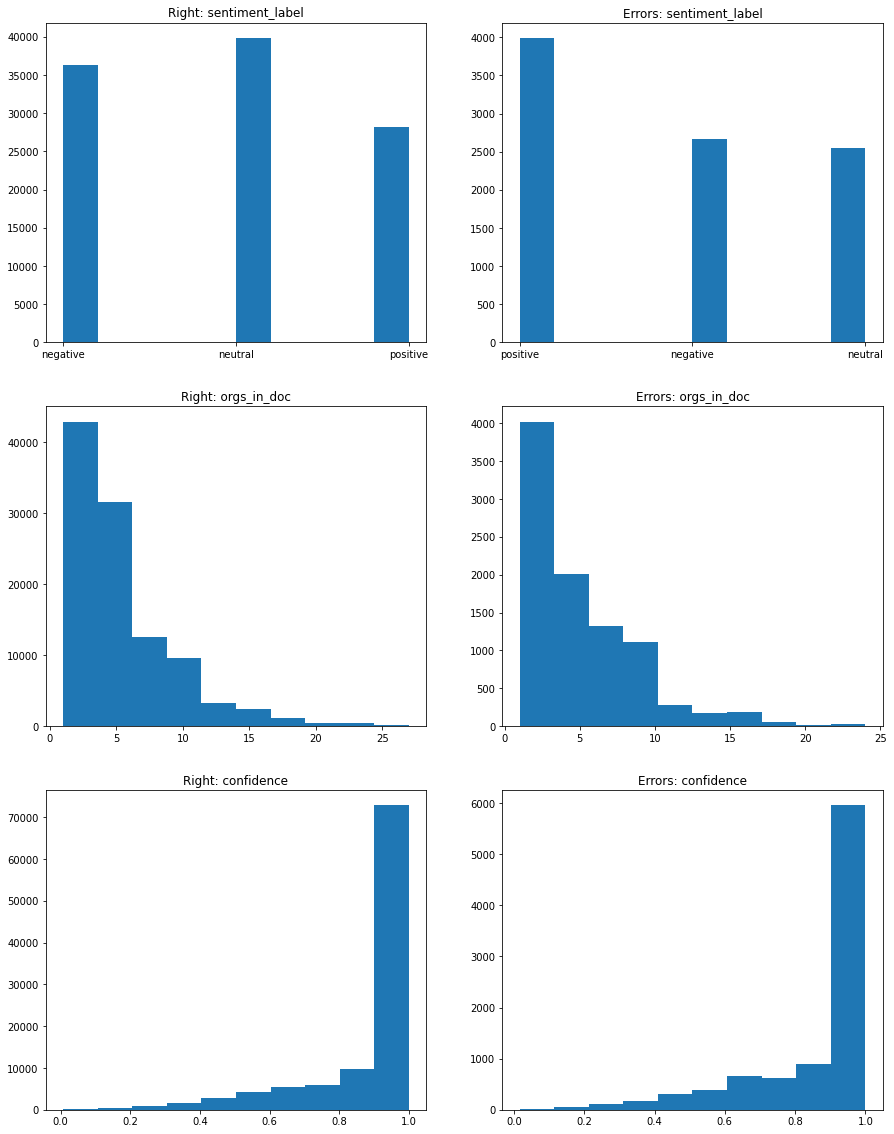

In [92]:
figure = plt.figure(figsize=(15,20))
columns_to_compare = ['sentiment_label','orgs_in_doc','confidence']
for i,column in enumerate(columns_to_compare):
    ax_right = figure.add_subplot(int(f'32{2*i+1}'))
    ax_errors = figure.add_subplot(int(f'32{2*i+2}'))
    ax_right.hist(right[column])
    ax_right.set_title(f'Right: {column}')
    ax_errors.hist(errors[column])
    ax_errors.set_title(f'Errors: {column}')

In [114]:
org_counts = errors.organization.value_counts()
org_counts = pd.concat([right.organization.value_counts(),org_counts], axis=1)
org_counts = pd.concat([org_counts,mixed_data['organization'].value_counts()],axis=1)
org_counts.columns = ['correct','error','total']

In [119]:
org_counts['error_ratio'] = org_counts['error']/org_counts['total']

In [121]:
org_counts[(org_counts['total'] > 100) & (org_counts['error_ratio'] > 0.15)]

,correct,error,total,error_ratio
Societe Generale,220.0,41.0,261,0.157088
Amazon.com,149.0,29.0,178,0.162921
FactSet,111.0,32.0,143,0.223776
Mizuho Securities,95.0,19.0,114,0.166667
Associated Press,85.0,16.0,101,0.158416


In [129]:
mixed_data['error'] = (mixed_data['sentiment_label_code'] != mixed_data['predicted_code'])

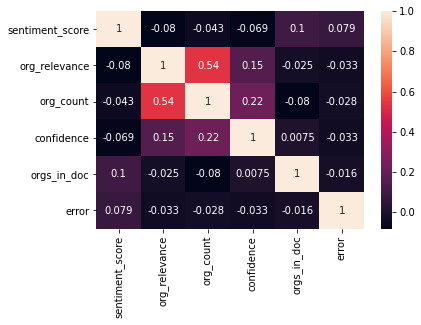

In [130]:
sns.heatmap(
    mixed_data[['sentiment_score','org_relevance','org_count','confidence','orgs_in_doc','error']].corr(), 
    annot=True
)

## Feature Importance

In [132]:
docs = pd.read_csv('docs_preprocessed.csv')
docs = docs[['uuid','site','author']]
docs.set_index('uuid',inplace=True)

In [138]:
orgs_w_docs = mixed_data.join(docs,on='uuid',how='left')
orgs_w_docs.fillna('No_info', inplace=True)

In [142]:
new_features = orgs_w_docs[['site','author', 'org_id']]

In [150]:
enc = OneHotEncoder()
enc.fit(new_features)

OneHotEncoder()

In [151]:
new_features_enc = enc.transform(new_features)

In [166]:
new_x = scipy.sparse.hstack([total_x, new_features_enc])

In [172]:
rf_classifier = RandomForestClassifier(n_estimators=5, max_features=1.0, max_depth=1000)
rf_classifier.fit(new_x,target['total'])

In [176]:
importance_w_index = [(i,importance) for i,importance in enumerate(rf_classifier.feature_importances_)]
sorted_importances = sorted(importance_w_index, key=lambda x:x[1], reverse=True)

In [185]:
names = enc.get_feature_names()
importances = pd.DataFrame(sorted_importances, columns=['index','importance'])

In [204]:
importances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82111 entries, 0 to 82110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       82111 non-null  int64  
 1   importance  82111 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


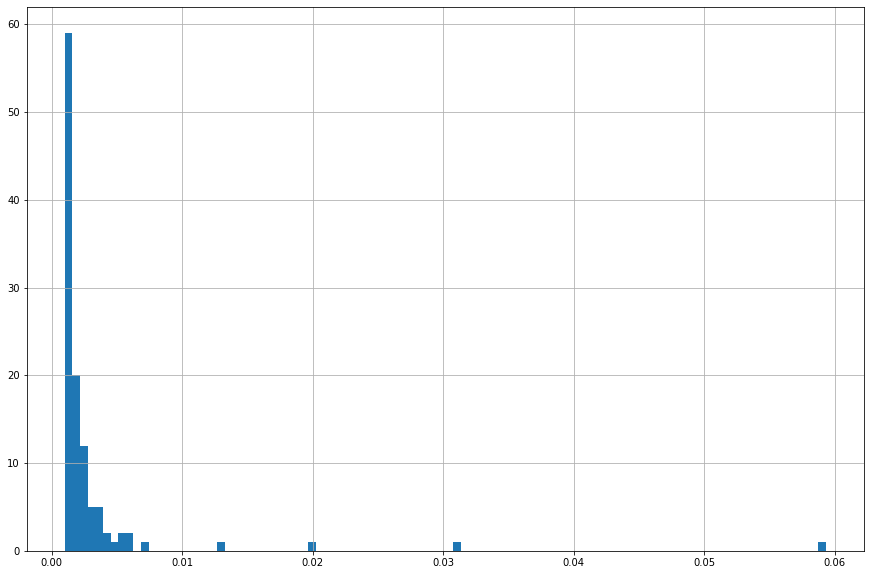

In [219]:
importances[(importances['importance'] > 0.001)]['importance'].hist(bins=100)
plt.gcf().set_size_inches(15,10)

In [ ]:
#69852 - длина вектора переменных без новых.
new_features_importance = [imp for imp in sorted_importances if imp[0]>=69852 and imp[1]>=0.001]

In [224]:
#x0 - источник
#x1 - автор
#x2 - org_id
[(names[imp[0]-69852], imp[1]) for imp in new_features_importance]

[('x1_cnbc.com', 0.012964441143929853),
 ('x2_ORG000535', 0.0054762916522201055),
 ('x1_No_info', 0.0034155071295789395),
 ('x0_reuters.com', 0.003215492977665137),
 ('x2_ORG000009', 0.0025737945122879823),
 ('x1_Reuters Editorial', 0.002140469436872073),
 ('x0_cnbc.com', 0.00212549963365032)]

In [229]:
orgs_w_docs[orgs_w_docs['org_id'].isin(['ORG000535','ORG000009'])]

,uuid,organization,sentiment_score,sentiment_label,org_relevance,org_count,confidence,orgs_in_doc,label,org_id,sentences,sentiment_label_code,predicted_code,error,site,author
93453,ba80a10e96ec194c1bf61d3e7366509b98090632,Reuters,-0.615847,negative,0.214725,2,0.980529,2,Reuters,ORG000009,recast lantern win bidder add statement weinst...,0,0,False,cnbc.com,cnbc.com
43963,0939a024389c4724ee01023be522ee55b6f9c1a6,Reuters,0.000000,neutral,0.132512,1,0.965973,1,Reuters,ORG000009,kcna org000009 north korea leader kim jong un ...,1,1,False,cnbc.com,No_info
94181,27c96298fc588436975d1a3d7eab141428685464,Reuters,-0.540004,negative,0.618031,4,0.999996,2,Reuters,ORG000009,london org000009 financial crisis hit decade a...,0,0,False,reuters.com,No_info
107380,19f87c99744a435a2986760c1c127ffb14ca4ac5,Reuters,-0.675386,negative,0.672979,4,0.999998,5,Reuters,ORG000009,se asia stock - most slump malaysia extend los...,0,0,False,reuters.com,No_info
82952,918132344b81311556a90b9432c49b06e15f10bc,REUTERS,0.000000,neutral,0.414108,2,0.985843,1,Reuters,ORG000535,japan concede gap trump remain trade framework...,1,1,False,reuters.com,No_info
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64952,93d3f926b2760d0c3ceb49f23211e1eb7e78080e,Reuters,0.654788,positive,0.326080,1,0.980320,1,Reuters,ORG000009,repeats wednesday article change text henning ...,2,2,False,reuters.com,Reuters Editorial
43232,1f50a072f017b5a3180a41939a8d296670c6973b,Reuters,-0.655114,negative,0.562368,2,0.998756,2,Reuters,ORG000009,org000009 u president donald trump meet senato...,0,0,False,reuters.com,Jarrett Renshaw
73196,3e57507946b353619bfb7baf3a44025530053e15,REUTERS,-0.451477,negative,0.774601,2,0.987927,2,Reuters,ORG000535,washington org000535 seven people employ sex a...,0,0,False,reuters.com,No_info
34434,ed51c98ecc0f97787e3627f2d834c148e7073d63,Reuters,-0.782405,negative,0.422969,3,0.991862,3,Reuters,ORG000009,accuse florida high school gunman face 17 murd...,0,0,False,reuters.com,No_info


In [232]:
orgs_w_docs['is_reuters'] = orgs_w_docs['organization'].str.lower().str.contains('reuters')

In [234]:
final_features = orgs_w_docs[['site','author','is_reuters']]

In [235]:
final_enc = OneHotEncoder()
final_enc.fit(final_features)

OneHotEncoder()

In [241]:
final_enc.get_feature_names()

array(['x0_cnbc.com', 'x0_fortune.com', 'x0_reuters.com', ...,
       'x1_wsjcom', 'x2_False', 'x2_True'], dtype=object)

In [236]:
final_features_enc = final_enc.transform(final_features)

In [238]:
final_x = scipy.sparse.hstack([total_x, final_features_enc])

In [239]:
train_x, test_x, train_y, test_y = train_test_split(
    final_x, target['total'],test_size=test_size, train_size=train_size, random_state=random_seed
)

In [242]:
train_data = lgb.Dataset(train_x, label=train_y)
test_data = lgb.Dataset(test_x, label=test_y, reference=train_data)

In [243]:
param = {
    'objective':'multiclass',
    'boosting': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'verbose':0,
}

In [244]:
param['num_iterations'] = 80
param['learning_rate'] = 0.3
param['num_leaves'] = 300
bst = lgb.train(param, train_data, valid_sets=[test_data])
pred_y = bst.predict(test_x).argmax(axis=1)
report = classification_report(test_y,pred_y)
logging.info(report)

/home/pontianak/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 8.300292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 0.954681
[2]	valid_0's multi_logloss: 0.87691
[3]	valid_0's multi_logloss: 0.825141
[4]	valid_0's multi_logloss: 0.786345
[5]	valid_0's multi_logloss: 0.755421
[6]	valid_0's multi_logloss: 0.730477
[7]	valid_0's multi_logloss: 0.710323
[8]	valid_0's multi_logloss: 0.692025
[9]	valid_0's multi_logloss: 0.67722
[10]	valid_0's multi_logloss: 0.662133
[11]	valid_0's multi_logloss: 0.650051
[12]	valid_0's multi_logloss: 0.639351
[13]	valid_0's multi_logloss: 0.629232
[14]	valid_0's multi_logloss: 0.620155
[15]	valid_0's multi_logloss: 0.611746
[16]	valid_0's multi_logloss: 0.603872
[17]	valid_0's multi_logloss: 0.597747
[18]	valid_0's multi_logloss: 0.590871
[19]	valid_0's multi_logloss: 0.585907
[20]	valid_0's multi_logloss: 0.581143
[2

INFO:root:              precision    recall  f1-score   support

           0       0.82      0.84      0.83     11683
           1       0.82      0.85      0.83     12773
           2       0.78      0.72      0.75      9615

    accuracy                           0.81     34071
   macro avg       0.80      0.80      0.80     34071
weighted avg       0.81      0.81      0.81     34071



In [252]:
lgb_train_data = lgb.Dataset(final_x, label=target['total'])

In [253]:
base_params = {
    'objective':'multiclass',
    'boosting': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'num_iterations': 80,
    'learning_rate': 0.3,
    'num_leaves': 300,
}
metrics = ['multi_logloss', 'multi_error']
lgb.cv(base_params,lgb_train_data, metrics=metrics)

/home/pontianak/.local/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 11.243588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48812
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 13770
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.329629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48812
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 13770
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.916894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48812
[LightGBM] [Info] Number of data points in the train set: 90855, number of used

{'multi_logloss-mean': [0.953674660869489,
  0.8756339553401832,
  0.8231356902476179,
  0.7840755845085094,
  0.7535101927372629,
  0.7285845904360961,
  0.7077598253791,
  0.68939313162467,
  0.6730492738377664,
  0.6587103435855381,
  0.6457317764318972,
  0.6346150184016652,
  0.6241319317009342,
  0.6148480163427856,
  0.6056365203517261,
  0.5972111034755814,
  0.5898674545265801,
  0.5832459023765575,
  0.5768433184636794,
  0.5713641304302047,
  0.566261418624481,
  0.5615295399098624,
  0.5573307659778786,
  0.5532356251980316,
  0.5492673277313538,
  0.5460035839247762,
  0.5425567706709562,
  0.5396946340680996,
  0.53683635000738,
  0.5343173712681608,
  0.5318787183262219,
  0.5297652535745321,
  0.527665243193015,
  0.5256669509742111,
  0.5237194280287836,
  0.5218113533383769,
  0.5199829928325849,
  0.5183142533606198,
  0.5167565985538063,
  0.5152773763312,
  0.5136796838222456,
  0.512272478199276,
  0.5109655437485129,
  0.5097190636034752,
  0.5084452353981133,
  

In [251]:
lgb_train_data = lgb.Dataset(new_x, label=target['total'])
lgb.cv(base_params,lgb_train_data, metrics=metrics)

/home/pontianak/.local/lib/python3.8/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 10.506533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50200
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 14464
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.644453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50200
[LightGBM] [Info] Number of data points in the train set: 90855, number of used features: 14464
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 5.469834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50200
[LightGBM] [Info] Number of data points in the train set: 90855, number of used

{'multi_logloss-mean': [0.9541303089717983,
  0.8760688188793431,
  0.824101059773185,
  0.786188175556707,
  0.7552923325882974,
  0.7306320766652007,
  0.709834960423302,
  0.6911318304652879,
  0.6747233646659268,
  0.6602275945682343,
  0.6473319809678568,
  0.6358930482944699,
  0.625395748022353,
  0.6154683551803631,
  0.6070437977128318,
  0.5991007881493469,
  0.5915928740709347,
  0.5847135310137146,
  0.5783648819849139,
  0.5727533851287364,
  0.5675002238990532,
  0.5626211769781682,
  0.5582429912677628,
  0.5541666639327447,
  0.5502667891807885,
  0.5469947846129569,
  0.5436669954405591,
  0.5408030924880445,
  0.5379979829726687,
  0.5353682397336279,
  0.5326624057211934,
  0.5303621256005571,
  0.5282710851066217,
  0.5260646900867583,
  0.5241472948817549,
  0.5223522148759205,
  0.52078398982748,
  0.5190727956802438,
  0.5173837213796407,
  0.5158833705411311,
  0.5142527222577558,
  0.5130785700420256,
  0.5115982964992617,
  0.5099859878935361,
  0.508848902648